### Analysis of Plasma proteomes based on MS1 and MS2 information

This jupyter notebook allows to analyze proteome discover output using exiting data from identified plasma proteins to re-score. 

In [10]:
import pandas as pd
import seaborn as sns
import re
import numpy as np 
import matplotlib.pyplot as plt
import math

Load the public plasma proteome: 

- **Gen**: Gen accession number
- **Description**: Protein name
- **Log_Conc**: Concentration Log2-based 
- **Zscore**: Zscore per proteins
- **Pvlue**: P value per proteins based on Zscore (probability in a normal distribution)

In [11]:
public_plasma_proteome = pd.read_csv("data/public-plasma-proteome.csv")
public_plasma_proteome.head()

,Gene,Description,Log_Conc,Zscore,PPvalue
0,ALB,Albumin,25.253497,4.531879,0.999997
1,CP,Ceruloplasmin,19.662752,3.489888,0.999758
2,GSN,Gelsolin,18.960138,3.358936,0.999609
3,RBP4,Retinol binding protein 4,18.680030,3.306730,0.999528
4,C3,Complement C3,17.931569,3.167234,0.999231


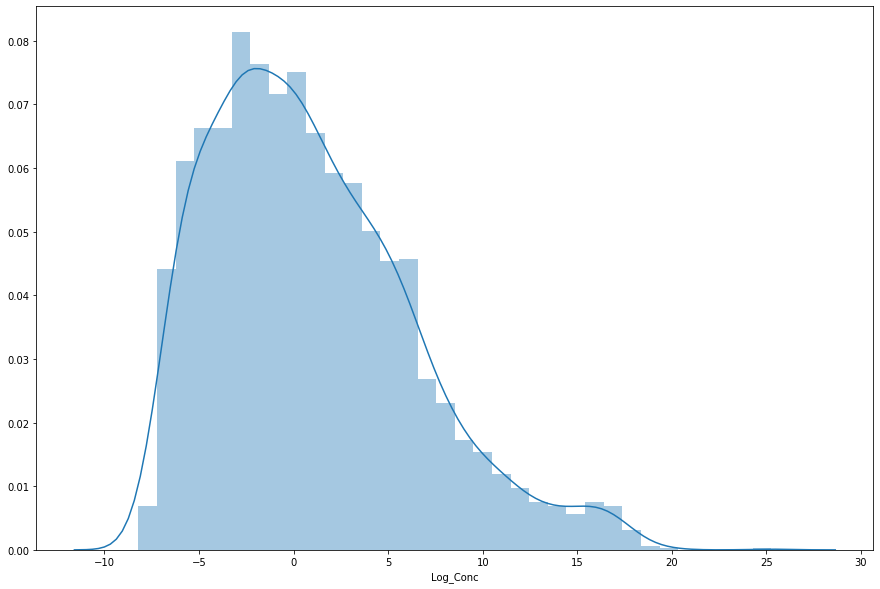

In [12]:
plt.figure(figsize=(15,10))
sns.distplot(public_plasma_proteome.Log_Conc)

Load internal database of plasma proteins: 

- **UniprotAccession**: Uniprot accession 
- **Pvalue**: P value based in the Zscore

In [13]:
inhouse_plasma_proteome = pd.read_csv("data/custom-plasma-proteome.csv")
inhouse_plasma_proteome.head()

,UniprotAccession,Pvalue
0,A0A075B6H7,0.380322
1,A0A075B6H9,0.493844
2,A0A075B6I0,0.590413
3,A0A075B6I1,0.238156
4,A0A075B6I4,0.238156


In [18]:
dataset = pd.read_csv("data/sample-all.csv")
dataset.head(1)

,UniprotAccession,Description,Globulins,# PSMs,Abundance[SUD0115],Abundance[SUD060],Abundance[SUD054],Abundance[SUD048],Abundance[SUD050],Abundance[SUD068],...,Found[SUD110],Found[SUD089],Found[SUD164],Found[SUD091],Found[SUD093],Found[SUD146],Found[SUD185],Found[SUD107],Found[SUD165],Gene
0,Q86WI1,Fibrocystin-L OS=Homo sapiens OX=9606 GN=PKHD1...,0,42,NaN,14183184.7,3420771.953,7688296.355,405479.4434,1098200.227,...,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,PKHD1L1


In [19]:
dataset = pd.merge(dataset, inhouse_plasma_proteome, on="UniprotAccession", how='outer')
dataset = pd.merge(dataset, public_plasma_proteome, on="Gene", how='outer')
dataset.head(1)

,UniprotAccession,Description_x,Globulins,# PSMs,Abundance[SUD0115],Abundance[SUD060],Abundance[SUD054],Abundance[SUD048],Abundance[SUD050],Abundance[SUD068],...,Found[SUD146],Found[SUD185],Found[SUD107],Found[SUD165],Gene,Pvalue,Description_y,Log_Conc,Zscore,PPvalue
0,Q86WI1,Fibrocystin-L OS=Homo sapiens OX=9606 GN=PKHD1...,0.0,42.0,NaN,14183184.7,3420771.953,7688296.355,405479.4434,1098200.227,...,Peak Found,Peak Found,Peak Found,Peak Found,PKHD1L1,0.671891,PKHD1 like 1,2.350497,0.263266,0.603827


## Compute probability for the inntsity of MS1 signals

The probability of the proteins identified with MS1 only signals is not the same that proteins identified with MS2 signals. 

For the proteins identified with MS1 signals the abundance is multiple for the probability to be be found in public databases: 

 - Abundance in Sample A for MS2 identifications = 1 * Abundance reported by the original search engine. 
 - Abundance in Sample A for MS1 identifications = existing_probability * Abundance transfered by the original search engine.
 - The exisiting probability is: 
   - If the protein is found in public databases = PValue_inhouse_plasmaDB + PValue_public_plasmaDB / (PValue_inhouse_plasmaDB * PValue_public_plasmaDB)
   - If the protein is not found in any of the databases = 0.009 . This means that we penalize those proteins as False positives. 

In [20]:
def compute_probability(row, sample):
    if np.isnan(row['Pvalue']):
        pvalue = 0
    else:
        pvalue = row['Pvalue']
    
    if np.isnan(row['PPvalue']):
        ppvalue = 0
    else:
        ppvalue = row['PPvalue']
        
    abundance = pvalue + ppvalue - (pvalue * ppvalue)
    if pvalue == 0 and ppvalue == 0:
        abundance = 0.009

    if row['Found[' + sample + ']'] == 'High':
        abundance = 1 * row['Abundance[' + sample + ']']
    if row['Found[' + sample + ']'] == 'Peak Found':
        abundance = abundance * row['Abundance[' + sample + ']']
    if row['Globulins'] == 1: 
        abundance = 1 * row['Abundance[' + sample + ']'] 

    return abundance

def is_decoy(row):
    decoy = 0
    if np.isnan(row['Pvalue']) and np.isnan(row['PPvalue']):
        decoy = 1
    if row['Found[' + sample + ']'] == 'High' or row['Globulins'] == 1:
        decoy = 0
    if row['Found[' + sample + ']'] == 'Not Found':
        decoy = math.nan
    return decoy

samples = []
for column in list(dataset.columns.values):
    m = re.search(r"\[([A-Za-z0-9_]+)\]", column)
    if m is not None and (len(m.group(1))):
        samples.append(m.group(1))

samples = np.unique(np.array(samples))
for sample in samples:
    dataset['AbundanceRecall[' + sample + ']'] = dataset.apply(lambda row: compute_probability(row, sample), axis=1)
    dataset['Decoy[' + sample + ']'] = dataset.apply(lambda row: is_decoy(row), axis=1)
dataset.head(1)

,UniprotAccession,Description_x,Globulins,# PSMs,Abundance[SUD0115],Abundance[SUD060],Abundance[SUD054],Abundance[SUD048],Abundance[SUD050],Abundance[SUD068],...,AbundanceRecall[SUD153],Decoy[SUD153],AbundanceRecall[SUD164],Decoy[SUD164],AbundanceRecall[SUD165],Decoy[SUD165],AbundanceRecall[SUD185],Decoy[SUD185],AbundanceRecall[SUD24SEP],Decoy[SUD24SEP]
0,Q86WI1,Fibrocystin-L OS=Homo sapiens OX=9606 GN=PKHD1...,0.0,42.0,NaN,14183184.7,3420771.953,7688296.355,405479.4434,1098200.227,...,4.336201e+06,0.0,7.651993e+06,0.0,2.082954e+07,0.0,2.103453e+06,0.0,622596.095354,0.0


In [21]:
for sample in samples:
    dataset = dataset.sort_values(by=['AbundanceRecall[' + sample + ']'], ascending=False)
    fdr_values = []
    decoy_count = 0
    target_count = 0
    for index, row in dataset.iterrows():
        if row['Decoy[' + sample + ']'] == 1:
            decoy_count += 1
        elif row['Decoy[' + sample + ']'] == 0:
            target_count += 1
        fdr = float(decoy_count) / float(decoy_count + target_count)
        if math.isnan(row['Decoy[' + sample + ']']):
            fdr = math.nan
        fdr_values.append(fdr)
    dataset['FDR[' + sample + ']'] = fdr_values
dataset.head(1)

,UniprotAccession,Description_x,Globulins,# PSMs,Abundance[SUD0115],Abundance[SUD060],Abundance[SUD054],Abundance[SUD048],Abundance[SUD050],Abundance[SUD068],...,FDR[SUD107],FDR[SUD108],FDR[SUD110],FDR[SUD116],FDR[SUD146],FDR[SUD153],FDR[SUD164],FDR[SUD165],FDR[SUD185],FDR[SUD24SEP]
1763,P02768,Serum albumin OS=Homo sapiens OX=9606 GN=ALB P...,0.0,162949.0,1.990000e+11,1.590430e+11,1.581780e+11,1.427420e+11,9.317555e+10,1.808340e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Distribution of targets vs decoy proteins 

The following plots show the distribution targets (proteins in plasma databases) vs decoys (proteins not present in plasma databases). 

In [31]:
def plot_targets_vs_decoy(fdr_thershold: float = 1.0, bins = 20, hist=True, kde = True, heigth = 35):
    fig, axs = plt.subplots(int(len(samples)/2), 2, figsize=(15, heigth)) # adjust the geometry based on your number of columns to plot
    filter_proteins = [] 
    for ax, sample in zip(axs.flatten(), samples):
        filtered_dataset = dataset.loc[(dataset['FDR[' + sample + ']'] < fdr_thershold)]
        filtered_dataset = filtered_dataset.dropna(subset=['FDR[' + sample + ']'])
        
        targets = filtered_dataset.loc[filtered_dataset['Decoy[' + sample + ']'] == 0]
        filter_proteins = filter_proteins + targets['UniprotAccession'].to_list()
        decoys  = filtered_dataset.loc[filtered_dataset['Decoy[' + sample + ']']  == 1]
        
        ms2     = targets.loc[targets['Found[' + sample + ']'] == 'High']
        ms1     = filtered_dataset.loc[filtered_dataset['Found[' + sample + ']'] == 'Peak Found']
        
        targets = targets['AbundanceRecall[' + sample + ']'].to_list()
        
        decoys  = decoys['AbundanceRecall[' + sample + ']'].to_list()
        ms2     = ms2['AbundanceRecall[' + sample + ']'].to_list()
        ms1     = ms1['AbundanceRecall[' + sample + ']'].to_list()
    
        targets = sorted(i for i in targets if i >= 1)
        decoys  = sorted(i for i in decoys if i >= 1)
    
        ms2  = sorted(i for i in ms2 if i >= 1)
        ms1  = sorted(i for i in ms1 if i >= 1)
    
        targets = np.log2(targets)
        targets = sorted(i for i in targets)
        decoys  = np.log2(decoys)
        decoys  = sorted(i for i in decoys)
        
        ms2  = np.log2(ms2)
        ms1  = np.log2(ms1)
    
        sns.distplot(targets, bins = bins,  norm_hist=False, kde=kde, label='Target Proteins', hist=hist, ax = ax) 
        sns.distplot(decoys,bins   = bins, norm_hist=False, kde=kde,label='Decoy Proteins', hist=hist, ax = ax) 
    
        ax.legend(labels=['Target Proteins','Decoy Proteins'])
    
        ax.set_title('Sample Accession -- ' + sample + " FDR Thershold: " + str(fdr_thershold))  
        
    
    filter_proteins = list(set(filter_proteins))
    filter_dataset = dataset[dataset['UniprotAccession'].isin(filter_proteins)]
    return filter_dataset

,UniprotAccession,Description_x,Globulins,# PSMs,Abundance[SUD0115],Abundance[SUD060],Abundance[SUD054],Abundance[SUD048],Abundance[SUD050],Abundance[SUD068],...,FDR[SUD107],FDR[SUD108],FDR[SUD110],FDR[SUD116],FDR[SUD146],FDR[SUD153],FDR[SUD164],FDR[SUD165],FDR[SUD185],FDR[SUD24SEP]
1763,P02768,Serum albumin OS=Homo sapiens OX=9606 GN=ALB P...,0.0,162949.0,1.990000e+11,1.590430e+11,1.581780e+11,1.427420e+11,9.317555e+10,1.808340e+11,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1764,P02787,Serotransferrin OS=Homo sapiens OX=9606 GN=TF ...,0.0,38226.0,2.270156e+10,1.243149e+10,1.076574e+10,1.038412e+10,5.650410e+09,1.566871e+10,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1765,P02647,Apolipoprotein A-I OS=Homo sapiens OX=9606 GN=...,0.0,27063.0,1.874915e+10,1.162976e+10,1.262064e+10,9.321121e+09,1.200140e+10,1.941345e+10,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1769,P01023,Alpha-2-macroglobulin OS=Homo sapiens OX=9606 ...,1.0,50848.0,1.591797e+10,1.586207e+10,1.038732e+10,6.367889e+09,6.082546e+09,1.198582e+10,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1766,P01024,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE...,0.0,56586.0,1.776842e+10,1.134082e+10,1.178576e+10,8.678027e+09,4.599298e+09,1.264546e+10,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,Q8NHJ6,Leukocyte immunoglobulin-like receptor subfami...,1.0,2.0,NaN,NaN,NaN,NaN,7.883300e+04,1.176114e+05,...,NaN,NaN,NaN,NaN,NaN,0.119661,NaN,NaN,NaN,NaN
967,A6NI73,Leukocyte immunoglobulin-like receptor subfami...,1.0,3.0,NaN,NaN,1.480020e+05,6.880419e+04,1.342608e+04,7.186788e+04,...,0.060223,NaN,NaN,0.090909,NaN,NaN,NaN,NaN,NaN,NaN
1224,Q96H15,T-cell immunoglobulin and mucin domain-contain...,1.0,5.0,NaN,NaN,NaN,NaN,7.684444e+03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1599,Q93033,Immunoglobulin superfamily member 2 OS=Homo sa...,1.0,1.0,NaN,NaN,NaN,NaN,6.874665e+04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


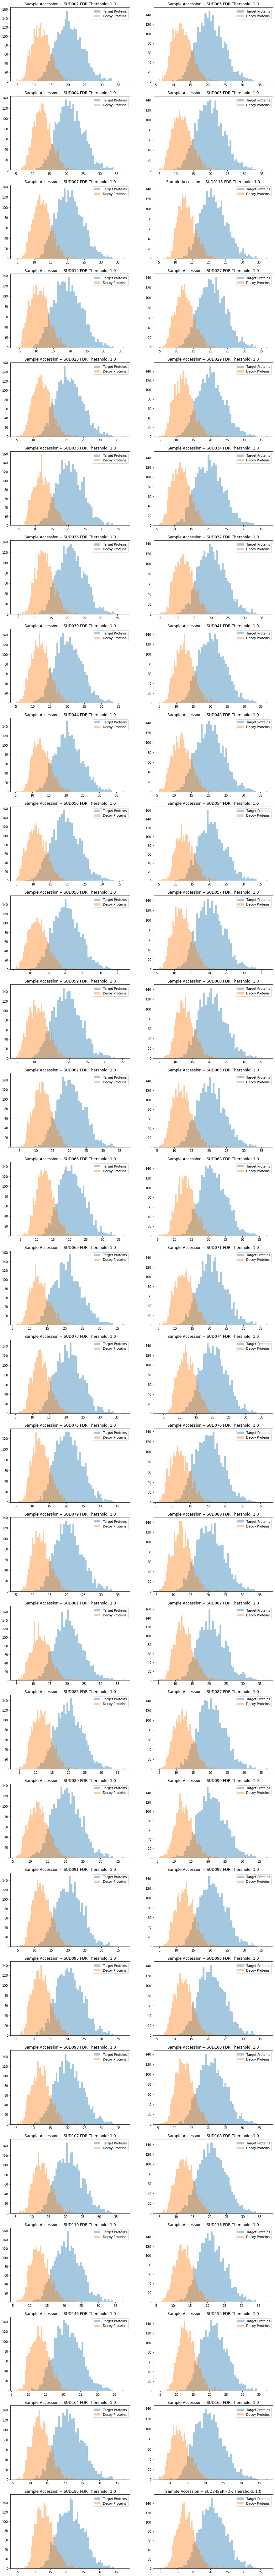

In [39]:
plot_targets_vs_decoy(fdr_thershold = 1.0, bins = 50 , kde = False, heigth = 150)

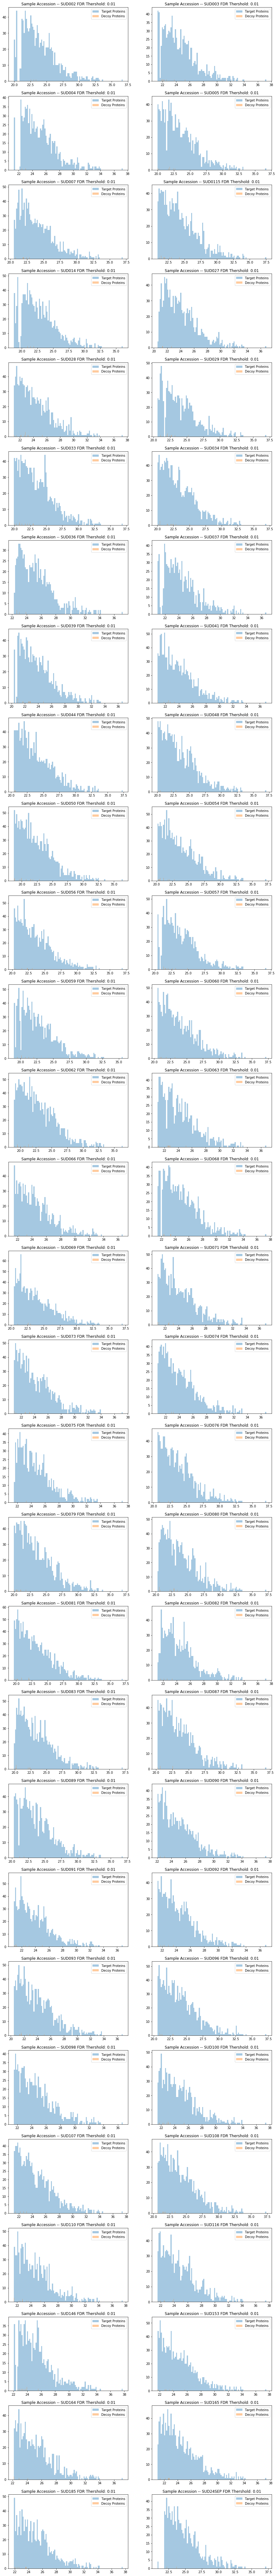

In [40]:
filter_dataset = plot_targets_vs_decoy(fdr_thershold = 0.01, bins = 100, hist = True, kde = False, heigth = 150)

## Quantification normalization across multiple samples. 

In [66]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import re

def get_sample(abundance: str): 
    m = re.search(r"\[([A-Za-z0-9_]+)\]", abundance)
    sample = m.group(1)
        
    return sample

def plot_quantification_box_plot(dataset, samples: list, method = None, weigth =15, rotation = 45):
    
    normalized = dataset.copy()
    samples_column = ['Abundance[' + sample + ']' for sample in samples]     
    
    if method is "robustscaler":
        scaler = RobustScaler()
        normalized[samples_column] = scaler.fit_transform(normalized[samples_column])
    if method is "minmax":
        scaler = MinMaxScaler()
        normalized[samples_column] = scaler.fit_transform(normalized[samples_column])
    
    samples_column = ['Abundance[' + sample + ']' for sample in samples]
    quantification_proteins = pd.DataFrame(columns=['Protein', 'Sample', 'Expression'])
    quantification_proteins = pd.melt(normalized, id_vars=['UniprotAccession'], value_vars=samples_column, var_name='Sample', value_name='Expression')
    
    np.seterr(divide = 'ignore')  
    quantification_proteins['Expression'] = np.log2(quantification_proteins['Expression']) 
    quantification_proteins['Sample'] = quantification_proteins['Sample'].apply(get_sample)
    
    plt.figure(figsize=(weigth,10))
    chart = sns.boxplot(x="Sample", y="Expression", data=quantification_proteins, palette="Set2")
    chart.set_xticklabels(chart.get_xticklabels(), rotation=rotation)


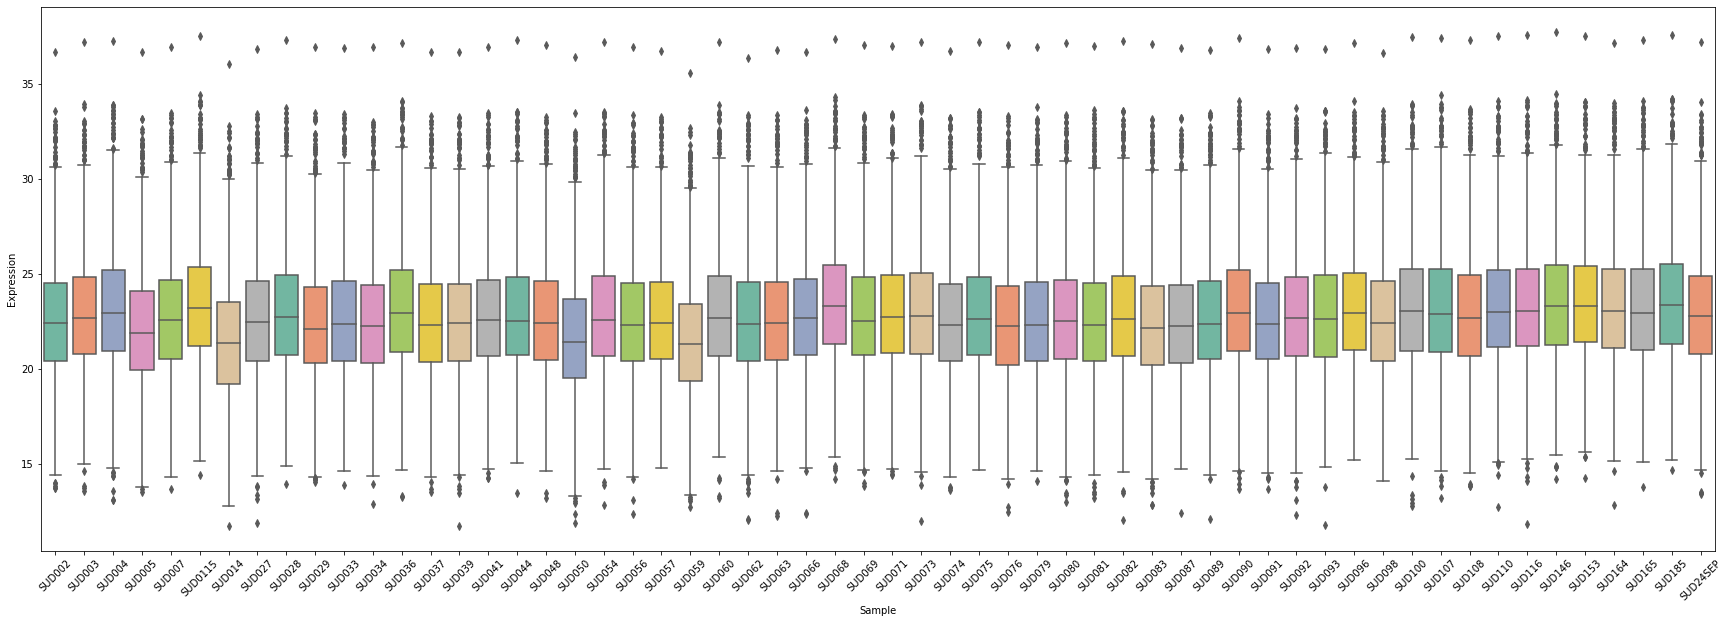

In [67]:
plot_quantification_box_plot(filter_dataset, samples, weigth = 30)

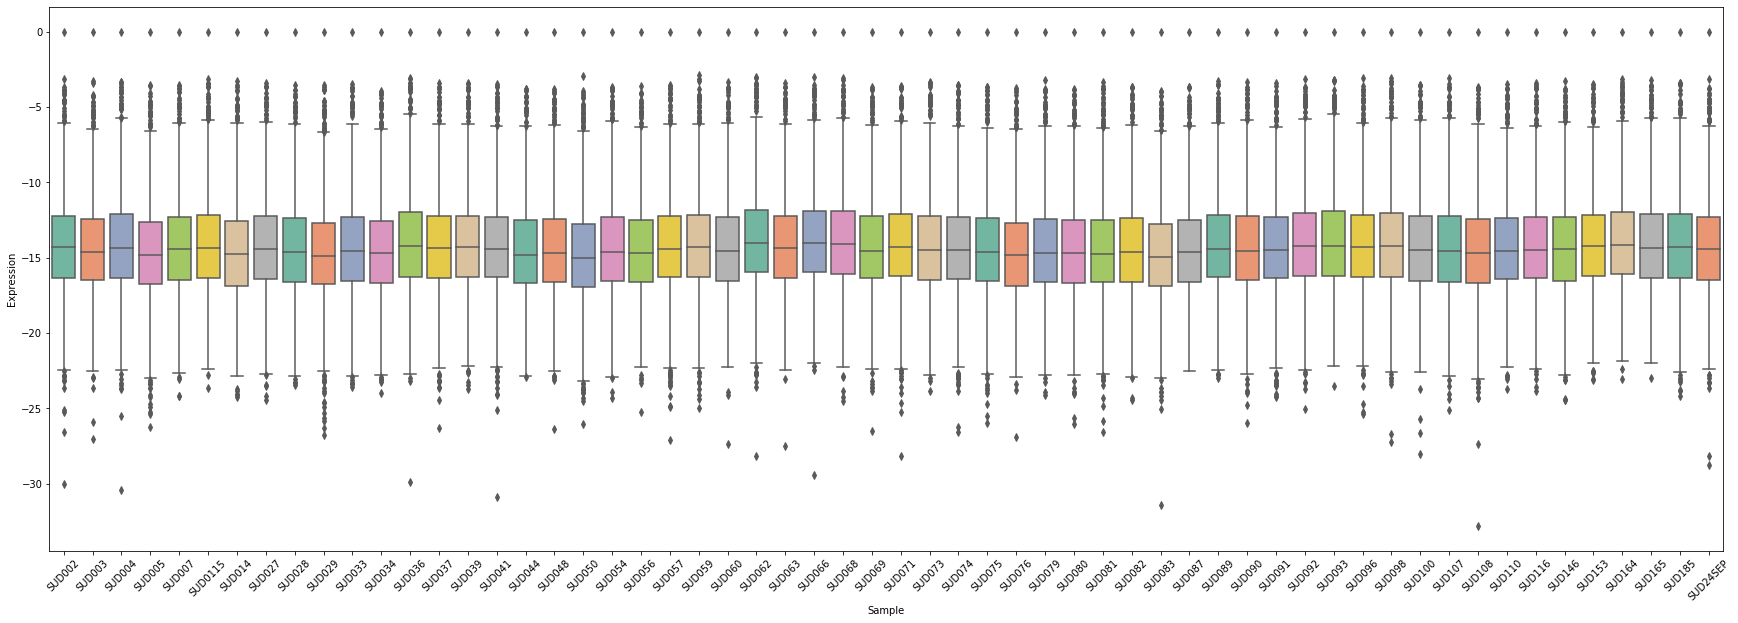

In [68]:
plot_quantification_box_plot(filter_dataset, samples, method = "minmax",  weigth = 30)

/Users/yperez/local-apps/miniconda3/envs/jupyternotebooks/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


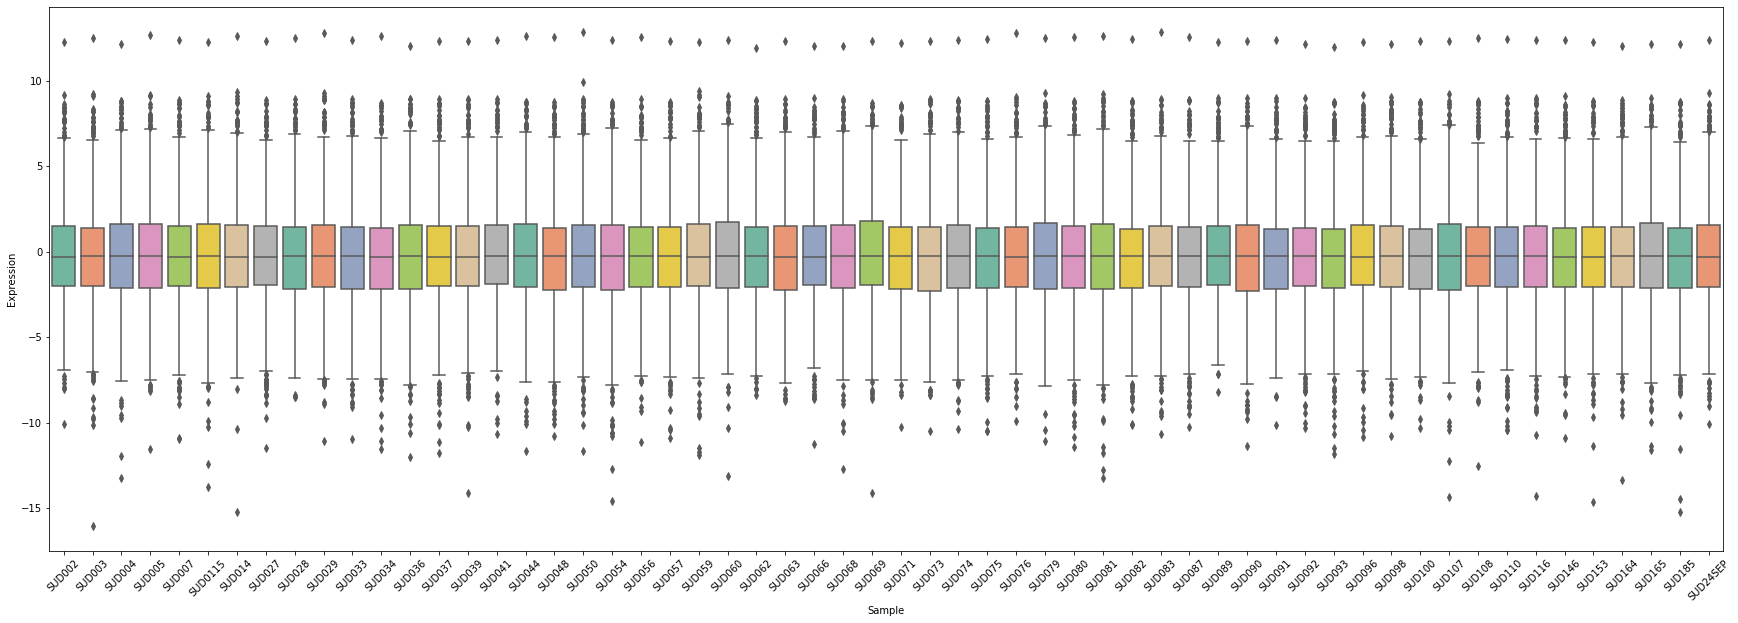

In [69]:
plot_quantification_box_plot(filter_dataset, samples, method = "robustscaler",  weigth = 30)

## Implement SVM to make the distributions more different and remove false positives.  

In [38]:
from sklearn import svm
from sklearn.model_selection import train_test_split